In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy
scipy.__version__

'1.4.1'

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
cd gdrive

/content/gdrive


In [5]:
cd MyDrive

/content/gdrive/MyDrive


In [6]:
cd omscs-dl-final-project

/content/gdrive/MyDrive/omscs-dl-final-project


In [27]:
import matplotlib.pyplot as plt
from IPython.display import Image 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import team36
from team36.mnist.vgg import VGG
# from team36.defenses.stat_def import VGG
from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet
from team36.defenses.fast_gradient_sign_method_loss import FastGradientSignMethodLoss
from team36.training import validate, accuracy, predict
from team36.diff_evo import differential_evolution
from team36.training import predict
import os
import sys
import numpy as np

In [21]:
DIR = "/content/gdrive/MyDrive/omscs-dl-final-project"
sys.path.append(os.path.abspath(DIR))
DATA_DIR = f'{DIR}/data'
NAME = "cifar10"
DATA_SET_CLASS = torchvision.datasets.CIFAR10
image_size = 32
in_channels = 3
fgsm_alpha = 0.5
fgsm_epsilon = 0.01

model = VGG(image_size=image_size, in_channels=in_channels)
if torch.cuda.is_available():
    model = model.cuda()
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg.pth")
model.load_state_dict(state_dict)

criterion = nn.CrossEntropyLoss()

# DIR = "/content/gdrive/MyDrive/omscs-dl-final-project"
# sys.path.append(os.path.abspath(DIR))
# DATA_DIR = f'{DIR}/data'
# NAME = "mnist"
# DATA_SET_CLASS = torchvision.datasets.MNIST
# image_size = 32
# in_channels = 3
# fgsm_alpha = 0.5
# fgsm_epsilon = 0.01

# model = model = VGG()
# if torch.cuda.is_available():
#     model = model.cuda()
# state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg.pth")
# model.load_state_dict(state_dict)

# criterion = nn.CrossEntropyLoss()

In [46]:
class OnePixelAttackDataSet(torch.utils.data.Dataset):
    def __init__(self, baseline_dataset, model, device=None):
        self.baseline_dataset = baseline_dataset
        self.model = model
        self.device = device

    def __getitem__(self, index):
        input, target = self.baseline_dataset[index]

        if self.device is not None:
            input = input.to(self.device)
            
        inputs = input.unsqueeze(0)
        
        flag, adversarial_input = self.attack(input, target, self.model)

        return adversarial_input, target

    def __len__(self):
        return len(self.baseline_dataset)

    def attack(self, img, label, net, target=None, pixels=3, maxiter=75, popsize=400, verbose=False):
      image_size = 32

      # img: 1*3*W*H tensor
      # label: a number
      # plt.figure()
      # plt.imshow(img[0][0].cpu().numpy())
      # print(label)
      with torch.no_grad():
          targeted_attack = target is not None
          target_class = target if targeted_attack else label

          bounds = [(0,image_size), (0,image_size), (0,255), (0,255), (0,255)] * pixels

          popmul = max(1, popsize/len(bounds))

          predict_fn = lambda xs: self.predict_classes(xs, img, target_class, net, target is None)
          callback_fn = lambda x, convergence: self.attack_success(
              x, img, target_class, net, targeted_attack, verbose)

          inits = np.zeros([int(popmul)*int(len(bounds)), int(len(bounds))])
          for init in inits:
              for i in range(pixels):
                  init[i*5+0] = np.random.random()*image_size
                  init[i*5+1] = np.random.random()*image_size
                  init[i*5+2] = np.random.normal(128,127)
                  init[i*5+3] = np.random.normal(128,127)
                  init[i*5+4] = np.random.normal(128,127)

          # print('starting differential_evolution')
          attack_result = differential_evolution(predict_fn, bounds, maxiter=maxiter, popsize=popmul,
              recombination=1, atol=-1, callback=callback_fn, polish=False, init=inits)
          # print("finished differential_evolution")
          attack_image = self.perturb_image(attack_result.x, img)
          # return (attack_image, label)
          # print(attack_image)
          # attack_var = Variable(attack_image, volatile=True).CUDA()
          predicted_probs = net(attack_image).softmax(dim = 1).data.cpu().numpy()[0]

          predicted_class = np.argmax(predicted_probs)

          x = (not targeted_attack and predicted_class != label)
          y = (targeted_attack and predicted_class == target_class)
          if x or y:
              # return 1, attack_result.x.astype(int)
              return 1, attack_image
          # return 0, [None]
          return 0, attack_image

    def predict_classes(self, xs, img, target_class, net, minimize=True):
        with torch.no_grad():
          imgs_perturbed = self.perturb_image(xs, img.clone())
      #     input = Variable(imgs_perturbed, volatile=True).cuda()
          predictions = net(imgs_perturbed).softmax(dim = 1).data.cpu().numpy()[:, target_class]

          return predictions if minimize else 1 - predictions

    def attack_success(self, x, img, target_class, net, targeted_attack=False, verbose=False):
      with torch.no_grad():
        attack_image = self.perturb_image(x, img.clone())
    #     input = Variable(attack_image, volatile=True).cuda()
        confidence = net(attack_image).softmax(dim = 1).data.cpu().numpy()[0]
        predicted_class = np.argmax(confidence)

        if (verbose):
          print("Confidence: %.4f"%confidence[target_class])
        cond_a = (targeted_attack and predicted_class == target_class)
        cond_b = (not targeted_attack and predicted_class != target_class)
        if cond_a or cond_b:
          return True

    def perturb_image(self, xs, img):
      with torch.no_grad():
        # plt.figure()
        # plt.imshow(img[0][0].cpu().numpy())
        if xs.ndim < 2:
            xs = np.array([xs])
        batch = len(xs)
        # batch = 32
        imgs = img.repeat(batch, 1, 1, 1)
        xs = xs.astype(int)

        count = 0
        for x in xs:
            pixels = np.split(x, len(x)/5)
            
            for pixel in pixels:
                x_pos, y_pos, r, g, b = pixel
                # print("x_pos, y_pos, r, g, b", x_pos, y_pos, r, g, b)
                imgs[count, 0, x_pos, y_pos] = (r/255.0-0.4914)/0.2023
                imgs[count, 1, x_pos, y_pos] = (g/255.0-0.4822)/0.1994
                imgs[count, 2, x_pos, y_pos] = (b/255.0-0.4465)/0.2010
            count += 1
        # x, _ = imgs[0]
        # display(transforms.functional.to_pil_image(imgs[0][0]))
        return imgs

test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())
attack_test_set = OnePixelAttackDataSet(test_set, model, device='cuda')

Files already downloaded and verified


In [39]:
DIR = "/content/gdrive/MyDrive/omscs-dl-final-project"
DATA_DIR = f'{DIR}/data'
NAME = 'cifar10'
DATA_SET_CLASS = torchvision.datasets.CIFAR10
image_size = 32
in_channels = 3
fgsm_alpha = 0.05
fgsm_epsilon = 0.1

sys.path.append(os.path.abspath(DIR))

In [40]:
model = VGG(image_size=image_size, in_channels=in_channels)
if torch.cuda.is_available():
    model = model.cuda()
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg.pth")
model.load_state_dict(state_dict)

defense_model = VGG(image_size=image_size, in_channels=in_channels)
if torch.cuda.is_available():
    defense_model = defense_model.cuda()
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg-training-with-fgsm-examples-defense-{fgsm_epsilon}.pth")
defense_model.load_state_dict(state_dict)

criterion = nn.CrossEntropyLoss()

fgsm_reg_defense_model = VGG(image_size=image_size, in_channels=in_channels)
if torch.cuda.is_available():
    fgsm_reg_defense_model = fgsm_reg_defense_model.cuda()
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg-training-with-fgsm-regularization-defense-{fgsm_epsilon}.pth")
fgsm_reg_defense_model.load_state_dict(state_dict)

# cpu_model = VGG(image_size=image_size, in_channels=in_channels)
# state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg.pth")
# cpu_model.load_state_dict(state_dict)
# fgsm_reg_defense_criterion = FastGradientSignMethodLoss(cpu_model, nn.CrossEntropyLoss(), 
#                                                         alpha=fgsm_alpha, epsilon=fgsm_epsilon)

<All keys matched successfully>

In [48]:
 torch.cuda.empty_cache()
test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

test_accuracy, _, test_loss = validate(None, test_loader, model, criterion)
defense_test_accuracy, _, defense_test_loss = validate(None, test_loader, defense_model, criterion)
fgsm_reg_defense_test_accuracy, _, fgsm_reg_defense_test_loss = validate(None, test_loader,
                                                                         fgsm_reg_defense_model, 
                                                                         fgsm_reg_defense_criterion,
                                                                         no_grad=False)

print("No Attack")
print(f"Test Accuracy is {test_accuracy}")
print(f"Test Loss is {test_loss}")

print(f"FGSM Examples Defense Test Accuracy is {defense_test_accuracy}")
print(f"FGSM Examples Defense Test Loss is {defense_test_loss}")

print(f"FGSM Regularization Defense Test Accuracy is {fgsm_reg_defense_test_accuracy}")
print(f"FGSM Regularization Defense Test Loss is {fgsm_reg_defense_test_loss}")

Files already downloaded and verified
No Attack
Test Accuracy is 0.7566999793052673
Test Loss is 0.7503899942398071
FGSM Examples Defense Test Accuracy is 0.7336999773979187
FGSM Examples Defense Test Loss is 0.778576318359375
FGSM Regularization Defense Test Accuracy is 0.7258999943733215
FGSM Regularization Defense Test Loss is 0.7922545544624329


In [56]:
test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())
# attack_test_set = OnePixelAttackDataSet(test_set, model, device='cuda')
# attack_test_loader = torch.utils.data.DataLoader(adversarial_input, batch_size=100, shuffle=False)

attack_test_set = OnePixelAttackDataSet(test_set, model, device='cuda')
indices = torch.randperm(len(attack_test_set))[:int(len(attack_test_set) * 0.1)]
attack_test_set = torch.utils.data.Subset(attack_test_set, indices)
attack_test_loader = torch.utils.data.DataLoader(attack_test_set, batch_size=100, shuffle=False)

attack_test_accuracy, _, attack_test_loss = validate(None, attack_test_loader, model, criterion)
attack_defense_test_accuracy, _, attack_defense_test_loss = validate(None, attack_test_loader, 
                                                                     defense_model, criterion)
attack_opa_reg_defense_test_accuracy, _, attack_opa_reg_defense_test_loss = validate(
    None, attack_test_loader, fgsm_reg_defense_model, fgsm_reg_defense_criterion, no_grad=False)


print("Attack")
print(f"Test Accuracy is {attack_test_accuracy}")
print(f"Test Loss is {attack_test_loss}")

print(f"FGSM Examples Defense Test Accuracy is {attack_defense_test_accuracy}")
print(f"FGSM Examples Defense Test Loss is {attack_defense_test_loss}")

print(f"FGSM Regularization Defense Test Accuracy is {attack_fgsm_reg_defense_test_accuracy}")
print(f"FGSM Regularization Defense Test Loss is {attack_fgsm_reg_defense_test_loss}")

Files already downloaded and verified


KeyboardInterrupt: ignored

In [36]:
attack_test_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, 
                                               transform=transforms.ToTensor())
attack_test_set = FastSignGradientAttackDataSet(attack_test_set, model, criterion, 
                                                               epsilon=0.01)

attack_test_loader = torch.utils.data.DataLoader(attack_test_set, batch_size=100, 
                                                 shuffle=False, num_workers=0)

attack_test_accuracy, _, attack_test_loss = validate(None, attack_test_loader, model, criterion)
# attack_defense_test_accuracy, _, attack_defense_test_loss = validate(None, attack_test_loader, 
#                                                                      defense_model, criterion)
attack_fgsm_reg_defense_test_accuracy, _, attack_fgsm_reg_defense_test_loss = validate(
    None, attack_test_loader, fgsm_reg_defense_model, fgsm_reg_defense_criterion, no_grad=False)


print(f"Attack Test Accuracy is {attack_test_accuracy}")
print(f"Attack Test Loss is {attack_test_loss}")

# print(f"Attack Defense Test Accuracy is {attack_defense_test_accuracy}")
# print(f"Attack Defense Test Loss is {attack_defense_test_loss}")

print(f"Attack FGSM Regularization Defense Test Accuracy is {attack_fgsm_reg_defense_test_accuracy}")
print(f"Attack FGSM Regularization Defense Test Loss is {attack_fgsm_reg_defense_test_loss}")

Files already downloaded and verified


RuntimeError: ignored

In [35]:

test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())
attack_test_set = OnePixelAttackDataSet(test_set, model, device='cuda', pixels = 3)
# index = 1 # mnist
index = 0 # cifar10

input, ground_truth = test_set[index]
input = input.cuda()

Files already downloaded and verified


Files already downloaded and verified
ground truth 3
no attack 3

input torch.Size([3, 32, 32])
adversarial_input torch.Size([3, 32, 32])
attack, no defense 5


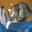


attack, FGSM training defense 8


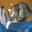


attack, FGSM loss defense 0


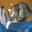

In [52]:

test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())
attack_test_set = OnePixelAttackDataSet(test_set, model, device='cuda')
# index = 1 # mnist
index = 0 # cifar10

input, ground_truth = test_set[index]
input = input.cuda()


print("ground truth", ground_truth)

print("no attack", predict(model, input))
# display(transforms.functional.to_pil_image(input))
print()

adversarial_input, _ = attack_test_set[index]
adversarial_input = adversarial_input.cuda().squeeze(0)
print("input", input.shape)
print("adversarial_input", adversarial_input.shape)
print("attack, no defense", predict(model, adversarial_input))
display(transforms.functional.to_pil_image(adversarial_input))
print()

print("attack, FGSM training defense", predict(defense_model, adversarial_input))
display(transforms.functional.to_pil_image(adversarial_input))
print()

print("attack, FGSM loss defense", predict(fgsm_reg_defense_model, adversarial_input))
display(transforms.functional.to_pil_image(adversarial_input))
print()

image_dir = f"{DIR}/images"

pil_image = transforms.functional.to_pil_image(input)
pil_image.save(f"{image_dir}/{NAME}-{str(index)}.png")

pil_image = transforms.functional.to_pil_image(adversarial_input)
pil_image.save(f"{image_dir}/{NAME}-{str(index)}-{fgsm_epsilon}-fgsm-adversarial.png")

In [53]:
test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor() )
attack_test_set = OnePixelAttackDataSet(test_set, model, device='cuda')
count = 0
attack_count = 0
total = 1000
for i in range(total):
  input, ground_truth = test_set[index]
  adversarial_input, _ = attack_test_set[index]
  adversarial_input = adversarial_input[0]

  prediction = predict(fgsm_reg_defense_model, input.cuda())
  attack_prediction = predict(fgsm_reg_defense_model, adversarial_input.cuda())

  if prediction == ground_truth:
    count += 1

  if attack_prediction == ground_truth:
    attack_count += 1

print("test accuracy", count / total)
print("attack test accuracy", attack_count / total)

Files already downloaded and verified
test accuracy 1.0
attack test accuracy 0.057


In [54]:
test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())
attack_test_set = OnePixelAttackDataSet(test_set, model, device='cuda')
count = 0
attack_count = 0
total = 1000
for i in range(total):
  input, ground_truth = test_set[index]
  adversarial_input, _ = attack_test_set[index]
  adversarial_input = adversarial_input[0]

  prediction = predict(defense_model, input.cuda())
  attack_prediction = predict(defense_model, adversarial_input.cuda())

  if prediction == ground_truth:
    count += 1

  if attack_prediction == ground_truth:
    attack_count += 1

print("test accuracy", count / total)
print("attack test accuracy", attack_count / total)

Files already downloaded and verified
test accuracy 1.0
attack test accuracy 0.192


In [50]:
test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())
attack_test_set = OnePixelAttackDataSet(test_set, model, device='cuda')
count = 0
attack_count = 0
total = 1000
for i in range(total):
  input, ground_truth = test_set[index]
  adversarial_input, _ = attack_test_set[index]
  adversarial_input = adversarial_input[0]

  prediction = predict(model, input.cuda())
  attack_prediction = predict(model, adversarial_input.cuda())

  if prediction == ground_truth:
    count += 1

  if attack_prediction == ground_truth:
    attack_count += 1

print("test accuracy", count / total)
print("attack test accuracy", attack_count / total)

Files already downloaded and verified
test accuracy 1.0
attack test accuracy 0.004
